1. Определите AUC_ROC и AUC_PR для модели логистической регрессии на тестовой выборке. Используйте реализацию модели в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.


____


In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

____

In [3]:
class LogisticRegression:

    def __init__(self, alpha=0.1, n_iter=2000):

        self.alpha = alpha
        self.n_iter = n_iter
        self.y_pred = None
        self.w = None
        self.y_proba = None
        self.proba_data = None

    @staticmethod
    def sigmoid(z):
        result = 1 / (1 + np.exp(-z))
        return result

    @staticmethod
    def logloss_calc(y, y_pred):
        err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
        return err

    def logloss_grad(self, X, w, y):
        n = X.shape[0]
        y_pred = self.sigmoid(np.dot(X, w))
        grad = (np.dot((y_pred - y), X))/n
        return grad

    def fit(self, X, y, n_iter=None, alpha=None, verbose=True):

        if not n_iter:
            n_iter = self.n_iter
        if not alpha:
            alpha = self.alpha
        w = np.random.randn(X.shape[1])
        for i in range(1, n_iter+1):
            y_pred = self.sigmoid(np.dot(X, w))
            err = self.logloss_calc(y, y_pred)
            w -= alpha * self.logloss_grad(X, w, y)

            if verbose:
                if i % 500 == 0:
                    print(
                        f'Итерация № {i}, вектор весов {w}, log loss {err}', sep='\n')
        self.w = w

    def predict_proba(self, X):
        y_proba = self.sigmoid(np.dot(X, self.w))
        return y_proba

    def predict(self, X, thr=0.5):

        self.y_proba = self.predict_proba(X)
        self.y_pred = np.zeros(self.y_proba.shape, dtype=bool)
        self.y_pred[self.y_proba > thr] = 1
        self.y_pred[self.y_proba <= thr] = 0
        return self.y_pred

    def metrics(self, y_true, y_pred, metric='f1_score', f1_beta=1):

        TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
        FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
        FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))
        TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
        accuracy = (TP + TN) / y_true.shape[0]
        precision = TP/(TP + FP)
        recall = TP/(TP + FN)
        f1_score = (1 + f1_beta**2)*(precision * recall) / \
            (f1_beta * precision + recall)

        if metric == 'accuracy':
            return accuracy
        if metric == 'pre_rec':
            return round(precision, 3), round(recall, 3)
        if metric == 'f1_score':
            return f1_score
        if metric == 'matrix':
            return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

    def get_proba_data(self, y_true):

        self.proba_data = pd.DataFrame(
            {'proba': self.y_proba, 'y_true': y_true})
        self.proba_data = self.proba_data.sort_values(
            by='proba', ascending=False).reset_index(drop=True)

    def roc_auc(self, y_true):

        if self.proba_data is None:
            self.get_proba_data(y_true)
        N = len(y_true)
        n_pos = np.count_nonzero(y_true)
        n_neg = N - n_pos
        TP = 0
        FP = 0
        TPR = [0]
        FPR = [0]
        for i in range(N):
            if self.proba_data.iloc[i, 1] == 1:
                TP += 1
            else:
                FP += 1
            TPR.append(TP/n_pos)
            FPR.append(FP/n_neg)
        ROC_AUC = np.trapz(TPR, x=FPR, dx=0.1)

        plt.figure(figsize=(12, 8))
        plt.plot(FPR, TPR, color='b', linewidth=2,
                 label=f'ROC curve\nROC_AUC = {round (ROC_AUC, 3)}')
        plt.plot((0, 1), (0, 1), color='dimgray',
                 linewidth=1, linestyle='dashed')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.fill_between(FPR, TPR, alpha=0.5, color='lightblue')
        if N <= 100:
            plt.scatter(FPR, TPR, edgecolors='white', s=55, c='dimgray')
        plt.legend(loc='best', facecolor='white', shadow=True, fontsize=15)
        plt.show()

    def pr_auc(self, y_true):

        if self.proba_data is None:
            self.get_proba_data(y_true)
        N = len(y_true)
        n_pos = np.count_nonzero(y_true)
        n_neg = N - n_pos
        TP = 0
        FP = 0
        recall = [0]
        precision = [0]
        
        for i in range(N):
            if self.proba_data.iloc[i, 1] == 1:
                TP += 1
            else:
                FP += 1
            recall.append(TP/n_pos)
            precision.append(TP/(TP + FP))
        PR_AUC = np.trapz(precision, x=recall, dx=0.1)

        plt.figure(figsize=(12, 8))
        plt.plot(recall, precision, color='b', linewidth=2,
                 label=f'PR curve\nPR_AUC = {round(PR_AUC, 3)}')
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.fill_between(recall, precision, alpha=0.5, color='lightblue')
        if N <= 100:
            plt.scatter(recall, precision, edgecolors='white', s=55, c='dimgray')
        plt.legend(loc='best', facecolor='white', shadow=True, fontsize=15)
        plt.show()

______

In [4]:
from sklearn import datasets

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=1000, n_features=10, n_informative=10,
                                       n_redundant=0, n_classes=2, random_state=1)

# classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
#                                        n_redundant=0, n_classes=2, random_state=1)

# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]

print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (700, 10)
Размер массива признаков тестовой выборки (300, 10)
Размер массива ответов для обучающей выборки (700,)
Размер массива ответов для тестовой выборки (300,)


In [5]:
log_class = LogisticRegression()
log_class.fit(X_train, y_train)

Итерация № 500, вектор весов [ 1.10746179 -0.20994073 -0.15904968  0.28391764 -0.14508797 -0.20556485
  0.60461708  0.82138787 -0.85201425 -0.41502976], log loss 0.279593751221615
Итерация № 1000, вектор весов [ 1.12565904 -0.21177385 -0.16475369  0.29146826 -0.15037829 -0.20355352
  0.61470512  0.83577966 -0.86162662 -0.41990128], log loss 0.27956231718935143
Итерация № 1500, вектор весов [ 1.12636877 -0.21184495 -0.16497051  0.29176055 -0.15058419 -0.2034816
  0.61509716  0.83634142 -0.86200545 -0.4200963 ], log loss 0.27956226992958316
Итерация № 2000, вектор весов [ 1.12639695 -0.21184777 -0.1649791   0.29177215 -0.15059236 -0.20347876
  0.61511273  0.83636373 -0.86202051 -0.42010406], log loss 0.27956226985508353


In [6]:
y_train_pred = log_class.predict(X_train)
y_test_pred = log_class.predict(X_test)
print(f'Вектор весов: {log_class.w}', sep='\n')
print('*' * 100)

print(
    f'Метрика accuracy для train: {log_class.metrics(y_train, y_train_pred, metric="accuracy"):.3f}')
print(
    f'Метрика accuracy для test: {log_class.metrics(y_test, y_test_pred, metric="accuracy"):.3f}')
print(
    f'Метрика f1_score для test: {log_class.metrics(y_test, y_test_pred, metric="f1_score"):.3f}')
print(
    f'Метрики precision и recall для test: {log_class.metrics(y_test, y_test_pred, metric="pre_rec")}')
print(
    f'Матрица ошибок для test: {log_class.metrics(y_test, y_test_pred, metric="matrix")}')

Вектор весов: [ 1.12639695 -0.21184777 -0.1649791   0.29177215 -0.15059236 -0.20347876
  0.61511273  0.83636373 -0.86202051 -0.42010406]
****************************************************************************************************
Метрика accuracy для train: 0.900
Метрика accuracy для test: 0.887
Метрика f1_score для test: 0.891
Метрики precision и recall для test: (0.863, 0.921)
Матрица ошибок для test: {'TP': 139, 'FP': 22, 'FN': 12, 'TN': 127}


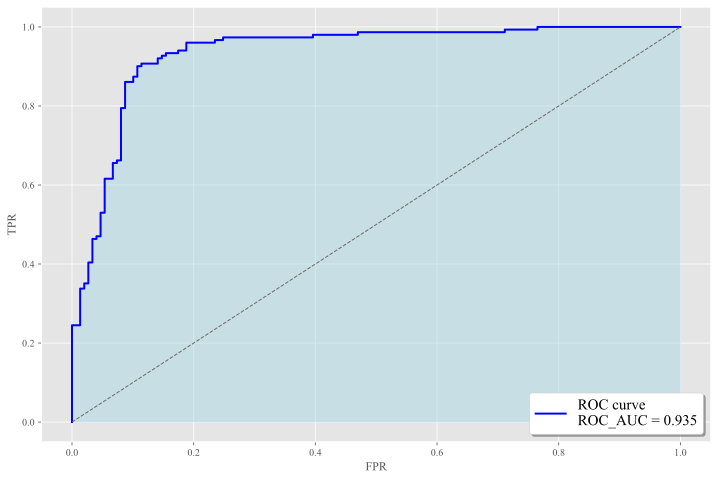

In [7]:
# построим ROC кривую, определим ROC AUC

log_class.roc_auc(y_test)

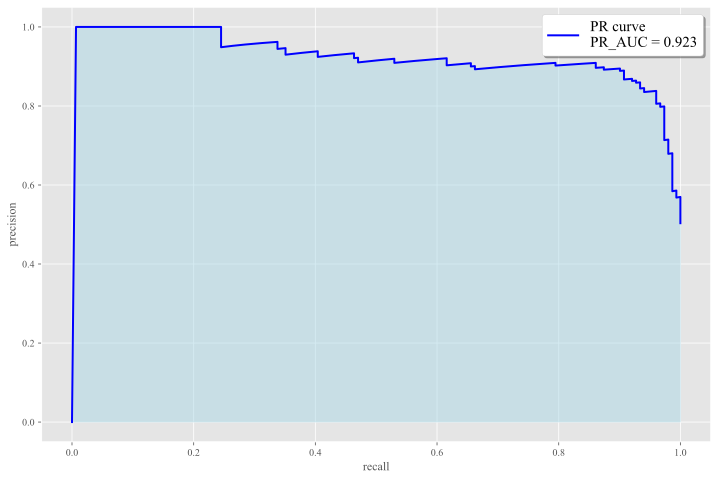

In [8]:
# построим PR кривую, определим PR AUC

log_class.pr_auc(y_test)